# The Northwind Database: Do Discounts Matter and Other Analysis

Northwind Traders Access database is a sample database that was created by Microsoft. The database houses sales data for a fictitious company called Northwind Traders, which imports and exports specialty foods from around the world. 

We will be asking a few questions trhoughout the analysis and each one will be addressed using hypothesis testing.

Below you can see the schema for the database.  The Schema provided below has some typos in it so some of our code will be slightly different than what is listed in the map
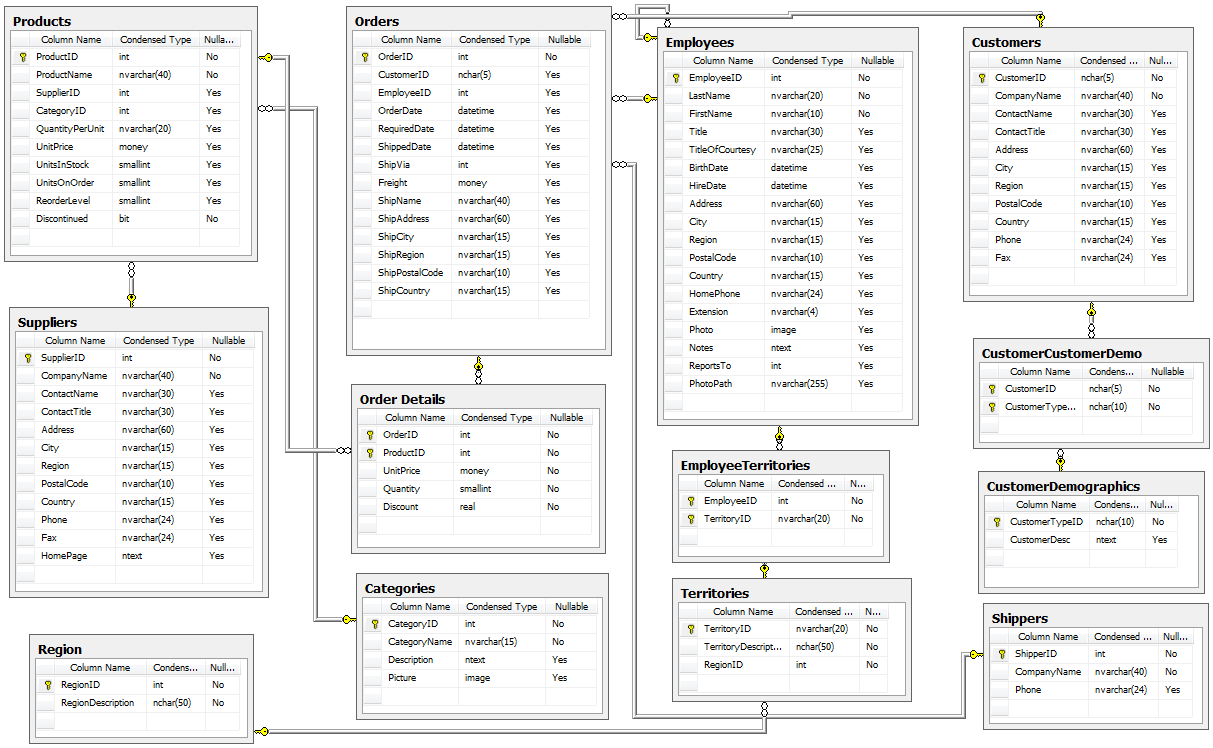

The tests we will perform will be at a 5% alpha or a 95% confidence level. 

We'll start with importing the necessary libraries.

In [1]:

import sqlite3 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from scipy import stats 
import itertools 
import statsmodels.api as sm 
from statsmodels.formula.api import ols

import warnings
warnings.filterwarnings('ignore') #keeping our notebook clean by ignoring the matplot warnings

In [2]:
# Creating a connection and a cursor object for the database
conn = sqlite3.connect('Northwind_small.sqlite')
c = conn.cursor()

In [3]:
# List of all tables
tables = c.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
tables = [i[0] for i in tables]
tables

['Employee',
 'Category',
 'Customer',
 'Shipper',
 'Supplier',
 'Order',
 'Product',
 'OrderDetail',
 'CustomerCustomerDemo',
 'CustomerDemographic',
 'Region',
 'Territory',
 'EmployeeTerritory']

Looks good so far.  We can make a loop now to put each table into a dataframe so we can operate on the full data set in pandas.

In [4]:
# inititating an empty list and iterating through each table in the table list and the database
#then converting it to a dataframe
data_list = []
for i in tables:
    table = c.execute('select * from "'+i+'"').fetchall()
    columns = c.execute('PRAGMA table_info("'+i+'")').fetchall()
    df = pd.DataFrame(table, columns=[i[1] for i in columns])
    # turning a string into variable name
    stringize = i+"_df"
    exec(stringize + " = df") # makeing the name of each dataframe match the database so that: TableName_df
    #adding to the list so we know what we have
    data_list.append(stringize)

In [5]:
#looking at our list and a the 'Order_df' dataframe head to make sure everything worked
print(data_list)
Order_df.head()

['Employee_df', 'Category_df', 'Customer_df', 'Shipper_df', 'Supplier_df', 'Order_df', 'Product_df', 'OrderDetail_df', 'CustomerCustomerDemo_df', 'CustomerDemographic_df', 'Region_df', 'Territory_df', 'EmployeeTerritory_df']


,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


In [6]:
Order_df.describe()

,Id,EmployeeId,ShipVia,Freight
count,830.000000,830.000000,830.000000,830.000000
mean,10662.500000,4.403614,2.007229,78.244205
std,239.744656,2.499648,0.779685,116.779294
min,10248.000000,1.000000,1.000000,0.020000
25%,10455.250000,2.000000,1.000000,13.380000
50%,10662.500000,4.000000,2.000000,41.360000
75%,10869.750000,7.000000,3.000000,91.430000
max,11077.000000,9.000000,3.000000,1007.640000


The loop worked out well and our dataframes appear to have loaded properly.  Let's explore our data and get a feel for whether the first question we asked is a reasonable one.

In [7]:
Product_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 10 columns):
Id                 77 non-null int64
ProductName        77 non-null object
SupplierId         77 non-null int64
CategoryId         77 non-null int64
QuantityPerUnit    77 non-null object
UnitPrice          77 non-null float64
UnitsInStock       77 non-null int64
UnitsOnOrder       77 non-null int64
ReorderLevel       77 non-null int64
Discontinued       77 non-null int64
dtypes: float64(1), int64(7), object(2)
memory usage: 6.1+ KB


For each of the 77 products let's see if the average quantity ordered is higher with a discount (or not!).  

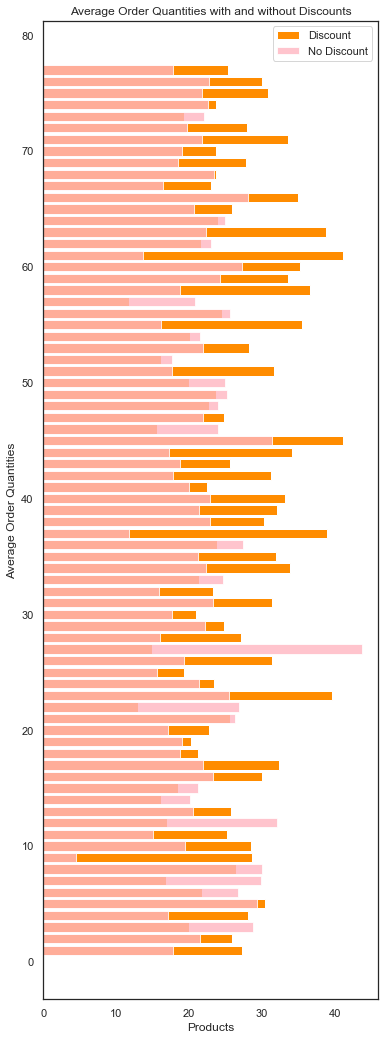

In [8]:
#setting the styling of our plots
sns.set(style = 'white', palette = 'bright')

#creating two line plots showing the average quanity with a discount and without a discount
disc = OrderDetail_df[OrderDetail_df['Discount']!=0].groupby('ProductId')['Quantity'].mean()
no_disc = OrderDetail_df[OrderDetail_df['Discount']==0].groupby('ProductId')['Quantity'].mean()
plt.figure(figsize=(6,18))
plt.barh(disc.index, disc.values, alpha=1, label='Discount', color = 'darkorange')
plt.barh(no_disc.index, no_disc.values, alpha=0.8, label='No Discount', color = 'lightpink')
plt.legend()



plt.title('Average Order Quantities with and without Discounts')
plt.xlabel('Products')
plt.ylabel('Average Order Quantities')
plt.show()


In [9]:
print('The Mean Order Size with a discount is ', round(np.array([disc]).mean(),3))
print('The Mean Order Size without a discount is ', round(np.array([no_disc]).mean(),3))

The Mean Order Size with a discount is  26.433
The Mean Order Size without a discount is  21.812


It looks like our hypothesis (that discounts do matter) is supported by the review above.  But what discount level matters the most?  We can sort our dataframe by discount and explore further.

In [10]:
#Showing each discount level
disc_lvl = OrderDetail_df['Discount'].unique()
disc_lvl.sort()
print('Discount levels :')
print(disc_lvl)

Discount levels :
[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.1  0.15 0.2  0.25]


We can now take our dataframe (OrderDetails_df) and group everything by discount amount.


In [11]:
discounts_df = OrderDetail_df.groupby('Discount').count()

In [12]:
discounts_df

,Id,OrderId,ProductId,UnitPrice,Quantity
Discount,,,,,
0.00,1317,1317,1317,1317,1317
0.01,1,1,1,1,1
0.02,2,2,2,2,2
0.03,3,3,3,3,3
0.04,1,1,1,1,1
0.05,185,185,185,185,185
0.06,1,1,1,1,1
0.10,173,173,173,173,173
0.15,157,157,157,157,157


The Next piece of information we want to review is the average order size for each discount level.  Once we have that created as a dictionary we should be able to add that as a column/series into our data frame.

In [13]:
#making an empty dictionary
Avg = {}

#Running a loop on ourempty dictionary to get the average size by discount level

for i in disc_lvl:
    xi = OrderDetail_df.loc[OrderDetail_df['Discount'] == i]
    Avg[i] = [xi['Quantity'].mean(),xi['Quantity'].count()]

#Always check to ensure everything worked so future steps are clean
Avg


{0.0: [21.715261958997722, 1317],
 0.01: [2.0, 1],
 0.02: [2.0, 2],
 0.03: [1.6666666666666667, 3],
 0.04: [1.0, 1],
 0.05: [28.01081081081081, 185],
 0.06: [2.0, 1],
 0.1: [25.23699421965318, 173],
 0.15: [28.38216560509554, 157],
 0.2: [27.024844720496894, 161],
 0.25: [28.24025974025974, 154]}

In [14]:
#setting up our new dataframe with the information we put into the Avg dictionary
    
disc_df = pd.DataFrame(Avg)
disc_df = disc_df.transpose()

#resetting the index so get Discounts as a column
disc_df.reset_index(inplace = True)

In [15]:
#renaming the columns 
disc_df.rename(index=str, columns={'index':'Discount', 0: "AvgQuantity", 1: "OrderCount"}, inplace = True)

#displaying our new dataframe
disc_df

,Discount,AvgQuantity,OrderCount
0,0.00,21.715262,1317.0
1,0.01,2.000000,1.0
2,0.02,2.000000,2.0
3,0.03,1.666667,3.0
4,0.04,1.000000,1.0
5,0.05,28.010811,185.0
6,0.06,2.000000,1.0
7,0.10,25.236994,173.0
8,0.15,28.382166,157.0
9,0.20,27.024845,161.0


Great! We have a new dataframe with only the summary of data that we need to complete our hypothesis tests.  The small number of orders for a 1-4%, and 6% discount might cause some trouble.  Let's remove them from our dataframe completely (it's only 0.4% of the whole dataset) and move forward.

In [16]:
#dropping our rows
disc_df = disc_df.drop(disc_df.index[[1,2,3,4,6]])
disc_df

,Discount,AvgQuantity,OrderCount
0,0.00,21.715262,1317.0
5,0.05,28.010811,185.0
7,0.10,25.236994,173.0
8,0.15,28.382166,157.0
9,0.20,27.024845,161.0
10,0.25,28.240260,154.0


Now we can start to answer our questions and do our testing. Remember that we said previously all of our tests will be done at a 5% alpha level.

In order to make our code cleaner we're going to make a few formulas that we can reuse for each test. 

## Formulas:

### Cohen's d

First we have Cohen's d, which is an effect size used to indicate the standardised difference between two means.  It helps us define the practicality of the siginificance and is widely used as an accompanyment to an ANOVA test and to conduct meta-analysis between studies.

In [17]:
def Cohen_d(grp1, grp2):
    # grp1: Dataframe Series or NumPy array
    # grp2: Datafrae Series or NumPy array
    
    #absolute difference between means
    diff = grp1.mean() - grp2.mean()
    
    #sample size and variance of each group
    n1, n2 = len(grp1), len(grp2)
    var1 = grp1.var()
    var2 = grp2.var()

    # pooled threshold 
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    # returns the absolute value of a floating point number 
    return abs(d)

### Visualization

Second, we will create a formula for our graphs so that we can quickly plot our findings. 


In [18]:
def visualization(control, test):
    plt.figure(figsize=(10,8))
    sns.distplot(test, bins=25,  label='Test')
    sns.distplot(control, bins=25,  label='Control')

    plt.axvline(x=control.mean(), color='darkorange', linestyle='--')
    plt.axvline(x=test.mean(), color='darkblue', linestyle='--')

    plt.title('Sampling Distributions', fontsize=14)
    plt.xlabel('Distributions')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()


## Bootstrap
Bootstrapping is a type of resampling where large numbers of smaller samples of the same size are repeatedly drawn, with replacement, from a single original sample.

In [19]:
#def bootstrap(sample, n):
#    bootstrap_sampling_dist = []
#    for i in range(n):
#        bootstrap_sampling_dist.append(np.random.choice(sample, size=len(sample), replace=True).mean())
#    return np.array(bootstrap_sampling_dist)

### Since we are doing hypothesis testing we should also clearly state our null and alternate hypotheses:


### Test 1 - Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?
#### Null Hypothesis =  Ho: There is no effect of Discount on the number of products per order

#### Alternate Hypothesis = Ha: There is a positive effect of having a discount and the number of products per order.

Because we have unequal variances in the two populations (with a discount and without) we can use the Welchs't test to see if they have equal means.  This should answer the first par of the question and we can do it with the Statsmodels library after we separate our population from our single dataframe.

In [20]:
#setting our test group and our control group
control1 = OrderDetail_df[OrderDetail_df['Discount']==0]['Quantity']
test1 = OrderDetail_df[OrderDetail_df['Discount']!=0]['Quantity']

P-value:  1.1440924523215966e-10
Reject Null Hypothesis
Cohen's d: 0.2863


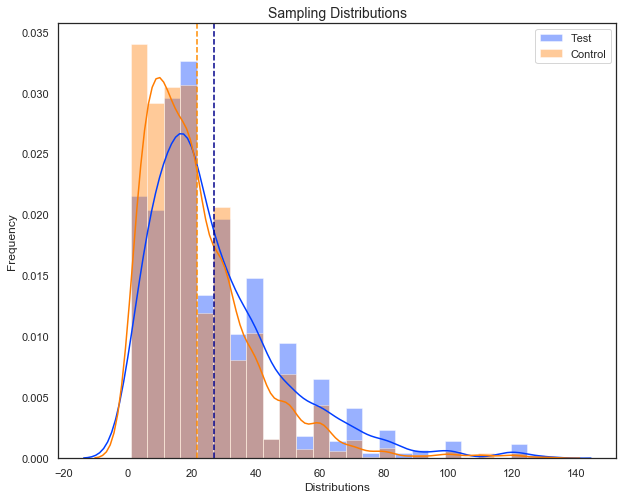

In [21]:
#running our test and using our Cohen's d formula 

t_stat, p = stats.ttest_ind(control1, test1)
Cd = Cohen_d(control1,test1)


#rejecting our null or failing to reject our null based on the above test
#we are using an alpha of 0.05/2 since this is a one tailed test 
print("P-value: ", p)
print('Reject Null Hypothesis') if p < 0.025 else print('Fail to Reject Null Hypothesis')
print("Cohen's d:", round(Cd,4))
visualization(control1, test1)

We can reject the null hypothesis that there is no effect of discounts on the order sizes given that the p-value is less than the alpha that we set.  Therefore we can conclude that there is a statistically significant difference in the mean order size of both groups.  You can see this quite clearly in the visualization above.

Now we have the second part of our question; at what discount level do we see the statistically significant difference in order quantity.  The general process will be the same but this time we will break everything down into groups by discount.

#### Null Hypothesis = Ho: There is no effect of Discount on the number of products per order
#### Alternate Hypothesis = Ha: There is a positive effect of having each one of the discounts [5%, 10%, 15%, 20%, 25%] and the number of products per order.

In [22]:
#making a new discount list to only incorporate those levels we kept in our dataframe
discounts = list(disc_df['Discount'])
discounts.pop(0)

#we can reuse our control variable from above and focus on the test set below
#first creating an empty dataframe with column headers
discounts_significance_df = pd.DataFrame(columns=['Discount','Null Hypothesis','Cohens d'], index=None)

#we can then make a loop to populate our dataframe showing the statistical significance of each discount level 
for i in discounts:
    test = OrderDetail_df[OrderDetail_df['Discount']==i]['Quantity']
    st, p = stats.ttest_ind(control1, test)
    d = Cohen_d(test, control1)
    discounts_significance_df = discounts_significance_df.append( {'Discount' : str(i*100)+'%' , 
                                                                   'Null Hypothesis' : 'Reject' if p < 0.025 
                                                                   else 'Fail to Reject', 'Cohens d' : d } , 
                                                                 ignore_index=True)    

discounts_significance_df

,Discount,Null Hypothesis,Cohens d
0,5.0%,Reject,0.346877
1,10.0%,Reject,0.195942
2,15.0%,Reject,0.372404
3,20.0%,Reject,0.300712
4,25.0%,Reject,0.366593


We can see here we rejected the null hypothesis in all cases.  There is a statistically significant difference in quantity between products that have a 5%, 10%, 15%, %20, and 25% discount and orders that have no discount at all.

## Let's ask our Second Question: 

### Test 2: Does the average revenue per order vary between regions?

#### Null Hypothesis = Ho: the average amount spent per order is the same between different regions.

#### Alternate hypothesis = Ha: the average amount spent per order is different between regions.


This is a two tailed test since we want to know a differece regardless of whether it is higher or lower.

Even though we have all the tables in the database available to us, we want to run a new SQL query because we will need to join two of those tables. 

In [23]:
#Writing our SQL statement to pull the info into a single table using two join statments
RegionOrder_df = pd.read_sql_query('''
 SELECT c.Region, od.OrderId, od.Quantity, od.UnitPrice, od.Discount
 FROM Customer c
 JOIN [Order] o ON c.Id = o.CustomerId
 JOIN OrderDetail od ON od.OrderId = o.Id
 ''', conn)

In [24]:
#Viewing our dataframe
RegionOrder_df.head()

,Region,OrderId,Quantity,UnitPrice,Discount
0,Western Europe,10248,12,14.0,0.0
1,Western Europe,10248,10,9.8,0.0
2,Western Europe,10248,5,34.8,0.0
3,Western Europe,10249,9,18.6,0.0
4,Western Europe,10249,40,42.4,0.0


In [25]:
# Calculating the revenue for each product in each order
RegionOrder_df['price_per_order'] = RegionOrder_df.Quantity * RegionOrder_df.UnitPrice * (1 - RegionOrder_df.Discount)

# Dropping the columns for quantity, unit price and discount now that we have the price per order
RegionOrder_df.drop(['Quantity', 'UnitPrice', 'Discount'], axis=1, inplace=True)

# Grouping the data by order and summing the revenue for each order
RegionOrder_df = RegionOrder_df.groupby(['Region', 'OrderId'])['price_per_order'].sum().reset_index()

# Dropping the OrderId as we no longer need this column
RegionOrder_df.drop('OrderId', axis=1, inplace=True)

In [26]:
RegionOrder_df.head()

,Region,price_per_order
0,British Isles,479.4
1,British Isles,2645.0
2,British Isles,1762.0
3,British Isles,516.8
4,British Isles,240.4


In [27]:
#Grouping the data by region to see how many orders are from each region
RegionOrder_df.groupby('Region').count()

,price_per_order
Region,
British Isles,75
Central America,21
Eastern Europe,7
North America,152
Northern Europe,55
Scandinavia,28
South America,127
Southern Europe,64
Western Europe,272


This time we will be using an ANOVA test for our hypothesis testing.  The ANOVA test measures degree of variation between multiple samples.  For us, sample is a different region.  Because there are some small sample sizes, and we have the requirement for ANOVA to have equal variance, we will need to combine some of the smaller regions.
 

In [28]:
# Combining Eastern Eurpoe and Southern Europe
RegionOrder_df.loc[(RegionOrder_df.Region == 'Eastern Europe') | (RegionOrder_df.Region == 'Southern Europe'),'Region'] = 'Southern and Eastern Europe'

# Combining Scandinavia and Northern Europe
RegionOrder_df.loc[(RegionOrder_df.Region == 'Scandinavia') | (RegionOrder_df.Region == 'Northern Europe'),'Region'] = 'Northern Europe and Scandinavia'

# Combining Central America  and South America
RegionOrder_df.loc[(RegionOrder_df.Region == 'Central America') | (RegionOrder_df.Region == 'South America'),'Region'] = 'South and Central America'

In [29]:
#Reviewing the dataframe to confirm
RegionOrder_df.groupby('Region').count()

,price_per_order
Region,
British Isles,75
North America,152
Northern Europe and Scandinavia,83
South and Central America,148
Southern and Eastern Europe,71
Western Europe,272


Let's look at some of the summary statistics of the data.

In [31]:
RegionOrder_df.groupby('Region').describe()

price_per_order                            \
                                          count         mean          std   
Region                                                                      
British Isles                              75.0  1452.682867  1618.645044   
North America                             152.0  1945.926977  2209.578928   
Northern Europe and Scandinavia            83.0  1345.799578  1502.782874   
South and Central America                 148.0  1075.918297  1447.262904   
Southern and Eastern Europe                71.0   686.727711   698.164184   
Western Europe                            272.0  1851.280914  2054.829054   

                                                                         \
                                   min        25%        50%        75%   
Region                                                                    
British Isles                    45.00  461.80000   997.0000  1879.8050   
North America                    36.00  533.55000  1260.9375  2411.4375   
Northern Europe and Scandinavia  48.75  486.25000   863.4300  1787.8000   
South and Central America        12.50  369.28125   817.6500  1419.2785   
Southern and Eastern Europe      18.40  157.70000   488.7000   854.6000   
Western Europe                   28.00  575.75000  1319.0975  2150.0500   

                                           
                                      max  
Region                                     
British Isles                    10835.24  
North America                    12615.05  
Northern Europe and Scandinavia  11188.40  
South and Central America        15810.00  
Southern and Eastern Europe       3026.85  
Western Europe                   16387.50

Another ANOVA assumption is that the data is normally distributed. We can log-transform the data now that we have our final groups to arrive at a more normally distributed dataset.

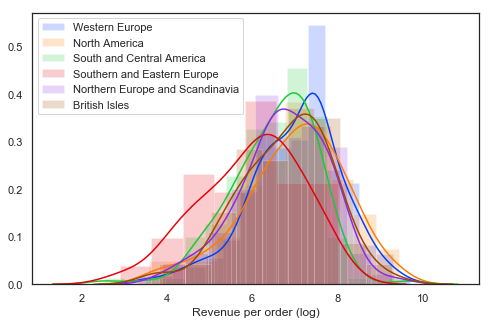

In [32]:
# log-transforming price_per_order into a dataframe copy
RegionOrder_log = RegionOrder_df.copy()
RegionOrder_log['price_per_order'] = np.log(RegionOrder_df['price_per_order'])

# Plotting the distributions for the log-transformed data by region
plt.figure(figsize=(8,5))
for region in set(RegionOrder_log.Region):
    region_group = RegionOrder_log.loc[RegionOrder_log['Region'] == region]
    sns.distplot(region_group['price_per_order'], hist_kws=dict(alpha=0.2), label=region)
    plt.legend()
    plt.xlabel('Revenue per order (log)')

In [33]:
# Fitting a model of price_per_order on Regional categories, and running our ANOVA test
lm = ols('price_per_order ~ C(Region)', RegionOrder_log).fit()
sm.stats.anova_lm(lm, typ=2)

,sum_sq,df,F,PR(>F)
C(Region),77.999547,5.0,13.032374,3.285724e-12
Residual,951.624641,795.0,NaN,NaN



Question 2
Is there a statistically significant difference in performance between employees from US and UK?
$H_0$: There is no difference in performance between US and UK employees
$H_\alpha$: there is a difference in performance between US and UK employees
How to measure performance of employee? It could be done in different ways, such a:

survey of the customers
amount of orders they were able to process
time it took them to procees the orders
etc...
To find out the difference in performance we will perform two tests

In [ ]:

employees_orders = pd.read_sql_query( '''
                                    
                                SELECT O.EmployeeId, E.Country, COUNT(O.Id) AS Total_Orders  
                                FROM [Order] AS O
                                JOIN Employee as E
                                ON O.EmployeeId = E.Id
                                GROUP BY O.EmployeeId
                                
                                ''' ,conn)

In [ ]:
employees_orders


Even without significance test we can tell there is a big difference in the amount of total orders two groups were able to process in two years.

2.1 Amount of orders processed by US and UK employees

In [ ]:

# ANOVA Test
formula = 'Total_Orders ~ C(Country)'
lm = ols(formula, employees_orders).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

Result of ANOVA Test shows that there is statistically significant difference in orders quantity between two groups of employees from USA and UK.

My suspicion was that group from USA covers larger territory, but it's turn out not to be the case.

I want to investigate further into performance of employees and compare their order processing time, maybe thats the reason in such a big difference in amount of orders

2.2 Order Processing Time by US vs UK Employees
In this test I want to figure out if number of orders affected by how fast employees can process them

In [ ]:
usa_uk = pd.read_sql_query('''
                    
                    SELECT O.Id, O.OrderDate, O.ShippedDate, E.Country FROM [Order] AS O
                    JOIN Employee AS E
                    ON O.EmployeeId = E.Id

''',conn)

In [ ]:

usa_uk.OrderDate = pd.to_datetime(usa_uk.OrderDate)
usa_uk.ShippedDate = pd.to_datetime(usa_uk.ShippedDate)
usa_uk['ProcessingTime'] = usa_uk.ShippedDate - usa_uk.OrderDate
usa_uk.ProcessingTime = usa_uk.ProcessingTime.dt.days

In [ ]:
usa_uk.dropna(inplace=True)

In [ ]:
usa = usa_uk[usa_uk.Country == 'USA']['ProcessingTime']
uk  = usa_uk[usa_uk.Country == 'UK']['ProcessingTime']

print(usa.mean(), uk.mean())
stats.ttest_ind(usa, uk)
print(Cohen_d(usa, uk))


Result of the test shows that there is no statistically significant difference in processing time, hence we falied to reject null hypothesis

Question 3
Is there statistically significant difference in discounts given by USA and UK employees?
$H_0$: There is no difference in discounts given by from USA and UK employees
$H_\alpha$: There is a difference in discounts given by from USA and UK employees
Read Database

In [ ]:

usa_uk_discount = pd.read_sql_query('''

                    SELECT OD.Discount, E.Country FROM [Order] AS O
                    JOIN OrderDetail AS OD ON O.Id = OD.OrderId
                    JOIN Employee AS E ON O.EmployeeId = E.Id

''', conn)

In [ ]:

formula = 'Discount ~ C(Country)'
lm = ols(formula, usa_uk_discount).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

Result
Result of the test shows that there is statistically significant difference in discount amount between employees from USA and UK, hence we reject null hypothesis

Employees from USA tend to give smaller discount to their clients

Question 4
Is there a statistically significant difference in demand of produce each month?
$H_0$: There is no difference in demand of produce each month
$H_\alpha$: There is a difference in demand of produce each month
Read Database

In [ ]:
produce = pd.read_sql_query('''

                                SELECT O.OrderDate, OD.Quantity, OD.Discount, CategoryId FROM [Order] AS O
                                JOIN OrderDetail AS OD
                                ON O.Id = OD.OrderId
                                JOIN Product
                                ON Product.Id = OD.ProductId
                                WHERE Product.CategoryId = 7

''',conn)

Group data by month

In [ ]:
produce.OrderDate = pd.to_datetime(produce.OrderDate)
produce['Month'] = produce.OrderDate.dt.month

In [ ]:
produce.groupby('Month').mean()

anova test


In [ ]:
formula = 'Quantity ~ C(Month)'
lm = ols(formula, produce).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)


Result
There is no statistically significant difference in order quantity between months, hence we failed to reject null hypothesis

Question 5
Is there a statistically significant difference in discount between categories?
$H_0$: There is no difference in discount level between categories
$H_\alpha$: There is a difference in discount level between categories
Read Database

In [ ]:
category_discount = pd.read_sql_query('''

                        SELECT OrderDetail.UnitPrice, Discount, CategoryId FROM OrderDetail
                        JOIN Product
                        ON OrderDetail.ProductId = Product.Id

''',conn)

ANOVA test

In [ ]:
formula = 'Discount ~ C(CategoryId)'
lm = ols(formula, category_discount).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

Result
Result of the test shows that there is no statistically significant difference in discount level between categories, hence we failed to reject null hypothesis

Question 6
Is there a statistically significant difference in performance of shipping companies?
$H_0$: There is no difference in discount level between categories
$H_\alpha$: There is a difference in discount level between categories

In [ ]:
Order_df.OrderDate = pd.to_datetime(Order_df.OrderDate)
Order_df.ShippedDate = pd.to_datetime(Order_df.ShippedDate)
Order_df.RequiredDate = pd.to_datetime(Order_df.RequiredDate)

Order_df['ProcessingTime'] = Order_df.ShippedDate - Order_df.OrderDate
Order_df['ShippingTime'] = Order_df.RequiredDate - Order_df.ShippedDate

Order_df.ShippingTime = Order_df.ShippingTime.dt.days
Order_df.ProcessingTime = Order_df.ProcessingTime.dt.days

In [ ]:
Order_df.groupby('ShipVia').mean()

In [ ]:
formula = 'ProcessingTime ~ C(ShipVia)'
lm = ols(formula, Order_df).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

In [ ]:
Shipper_df

Result
Result of the test shows that there is a statistically significant difference in performance of shipping companies, hence we reject null hypothesis

Conclusion
Discounts of 5%, 15%, 20% and 25% have approximately the same effect on order quantity
Employees from US sold more product with lower discount, though order quantity same as employees from UK and processing time (from order being requested to shipping) approximately the same.
There difference in demand of produce, but not significantly enough to reject null hypothesis
Discounts were given across categories at the relatively same level
Further Steps
Find out why employees from US had much more orders than from UK
Research further what clients responded better to discount
Find out optimal level of discount for products according to their price and possible seasonal demand
Find a way to improve logistics